In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
import torch

from utils.data_transform import Sentinel2Transform
from utils.sentinel_2_reader import S2Reader
from utils.data_loader import DataLoader

In [13]:
from torch.optim import Adam
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn import NLLLoss
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

from utils import train_valid_eval_utils as tveu
import shutil

# Data Download

In [4]:
from radiant_mlhub import Dataset

os.environ['MLHUB_API_KEY'] = '380ab1acf08f82cddc417ddaf61b6acbaceb0e6a125435e63b79d93efe0110c6'

if not os.path.exists('data/'):
    os.makedirs('data/')

In [3]:
# Brandenburg dataset
dataset = Dataset.fetch('dlr_fusion_competition_germany')
print(f'{dataset.id}: {dataset.title}')
dataset.download('data/')

NameError: name 'Dataset' is not defined

In [6]:
#South Africa dataset
dataset = Dataset.fetch('ref_fusion_competition_south_africa')
print(f'{dataset.id}: {dataset.title}')
dataset.download('data/')

ref_fusion_competition_south_africa: A Fusion Dataset for Crop Type Classification in Western Cape, South Africa


INFO:radiant_mlhub.client.catalog_downloader:unarchive ref_fusion_competition_south_africa.tar.gz ...
unarchive ref_fusion_competition_south_africa.tar.gz: 100%|██████████| 1792/1792 [00:00<00:00, 57352.31it/s]
INFO:radiant_mlhub.client.catalog_downloader:create stac asset list (please wait) ...
INFO:radiant_mlhub.client.catalog_downloader:1658 unique assets in stac catalog.
download assets: 100%|██████████| 1658/1658 [00:05<00:00, 280.47it/s]
INFO:radiant_mlhub.client.catalog_downloader:assets saved to data\ref_fusion_competition_south_africa


In [ ]:
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'
brandenburg_te_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/vector_labels.geojson'

In [ ]:
brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(brandenburg_tr_labels)))
brandenburg_tr_labels.info()
brandenburg_tr_labels.tail()

In [ ]:
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

print('INFO: Label IDs: {}'.format(label_ids))
print('INFO: Label Names: {}'.format(label_names))

In [ ]:
value_counts=brandenburg_tr_labels['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))

# Restore Sentinel 2 Germany Data

In [14]:
backup_test = "D:\data backup\dlr_fusion_competition_germany_test_source_sentinel_2"
backup_train = "D:\data backup\dlr_fusion_competition_germany_train_source_sentinel_2"

replace_test = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_test_source_sentinel_2"
replace_train = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2"

def copy_and_replace(src, dst):
    if os.path.isdir(src):
        if not os.path.exists(dst):
            os.makedirs(dst)
        files = os.listdir(src)
        for file in files:
            copy_and_replace(os.path.join(src, file), os.path.join(dst, file))
    else:
        shutil.copy2(src, dst)

In [15]:
copy_and_replace(backup_test, replace_test)
copy_and_replace(backup_train, replace_train)

# Exploring S2 Data

In [ ]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018"

In [ ]:
#INITIALIZE THE DATA READER TO OBSERVE THE FIELDS FROM PLANET DATA: 

# Choose some days of the year to plot
selected_data_indices = range(143) #beware that S2 data is not daily, 

#Initialize data reader for planet images
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir,
                                  label_dir=brandenburg_tr_labels_dir,
                                  selected_time_points=selected_data_indices)

# Working with Sentinel 2 Data

In [16]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

In [17]:
# Load the .npz file
data = np.load("data/ref_fusion_competition_south_africa/ref_fusion_competition_south_africa_train_source_sentinel_2/ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_258N_34S_19E_258N_2017/fid_75802.npz")

# Check the available data indices
print(data.files)
# available_indices = data['image_stack']
print(len(data['image_stack']))
# print("Available data indices:", available_indices)


['image_stack', 'cloud_stack', 'mask', 'feature']
76


In [18]:
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')

def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

def endvi(X):
    B8 = X[7]
    B4 = X[3]
    B2 = X[1]
    return 2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))

In [21]:
# Selected_time_interval can be left empty to exploit all available time points
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir)

crop_id, crop_name = label_ids[7], label_names[0]

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 13405.26it/s]


In [22]:
# Print Median value of each field for all days
median = []
days = []
iterable = iter(s2_reader)
while True:
    X, y, mask, _ = next(iterable)

    width = X.shape[-1]
    height = X.shape[-2]

    if y == crop_id and width > 60 and height > 60:
        for day in range(143):
            median.append(np.median(ndvi(X[day])))
            days.append(day)

        break

<function matplotlib.pyplot.show(close=None, block=None)>

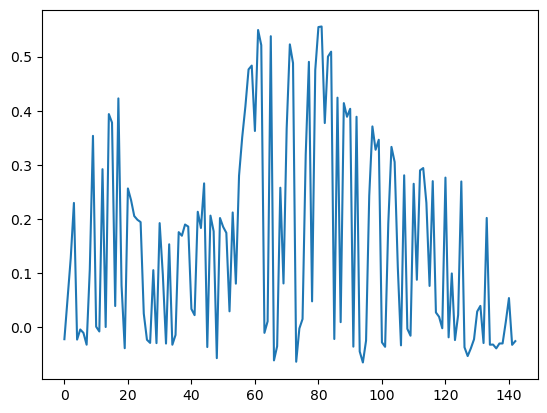

In [23]:
plt.plot(days, median)
plt.show

# Preprocessing?

In [26]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

In [30]:
data = np.load("data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/fid_3935.npz")
# Check the available data indices
print(data.files)
print(len(data['image_stack']))

['image_stack', 'cloud_stack', 'mask', 'feature']
144


In [32]:
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir)

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 14095.57it/s]


In [33]:
#Define NDVI index for S2 images
def ndvi(X):
    red = X[3]
    nir = X[7]
    return (nir-red) / (nir + red)

#Define True Color for S2 images
def true_color(X):
    blue = X[1]/(X[1].max()/255.0)
    green = X[2]/(X[2].max()/255.0)
    red = X[3]/(X[3].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')

In [37]:
#VISUALISE SOME OF THE FIELDS FROM S2 DATA: 
selected_data_indices = range(144)
#Initialize plot cells
num_row = len(selected_data_indices)
num_col = len(label_ids)
fig, axes = plt.subplots(num_row, num_col, figsize=(2.5*num_col,2*num_row))

#Display one sample field for each crop type
pbar = tqdm(total=len(label_ids))
iterable=iter(s2_reader)
for crop_id, crop_name in zip(label_ids,label_names):
    while True:
        # read a field sample
        X,y,mask,fid = next(iterable) 
        
        width=X.shape[-1]
        height=X.shape[-2]
        
        #Get one sample for each crop type, and
        #consider large areas (at least 60x60) to display
        if y == crop_id and width>60 and height>60:
            for i, day in enumerate(selected_data_indices):
                
                # Display RGB image of the field in a given week for a given crop type
                ax = axes[(2*i)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('RGB in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(true_color(X[i]))
                
                # Display NDVI index of the field in a given day for a given crop type
                ax = axes[(2*i+1)%num_row, crop_id%num_col]
                ax.title.set_text('{}'.format(crop_name))
                ax.set_ylabel('NDVI in Day {}'.format(day))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(ndvi(X[i]*mask),cmap=plt.cm.summer)
                
            #if one sample selected for a crop type, break the WHILE loop
            pbar.set_description("Plotting {} Fields".format(crop_name))
            pbar.update(1)
            break
        
        
plt.tight_layout()
plt.show()
pbar.set_description("Plotting Complete!")
pbar.close()

  0%|          | 0/9 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable int object

# Preparing Sentinel 2 data (Brandenburg)

In [20]:
brandenburg_s2_train_dir = "data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/"
brandenburg_tr_labels_dir='data/dlr_fusion_competition_germany/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/vector_labels.geojson'

brandenburg_tr_labels=gpd.read_file(brandenburg_tr_labels_dir)
label_ids=brandenburg_tr_labels['crop_id'].unique()
label_names=brandenburg_tr_labels['crop_name'].unique()

In [5]:
zipped_lists = zip(label_ids, label_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
label_ids, label_names = [ list(tuple) for tuple in  tuples]

In [6]:
sentinel_2_transformer=Sentinel2Transform()
s2_reader = S2Reader(input_dir=brandenburg_s2_train_dir, label_dir=brandenburg_tr_labels_dir, label_ids=label_ids, transform=sentinel_2_transformer.transform, min_area_to_ignore=1000,include_cloud=False)

data_loader=DataLoader(train_val_reader=s2_reader, validation_split=0.25)

INFO: Ignoring 30/2534 fields with area < 1000m2


INFO: Extracting time series into the folder: data\dlr_fusion_competition_germany\dlr_fusion_competition_germany_train_source_sentinel_2\dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/: 100%|██████████| 2504/2504 [00:00<00:00, 6728.80it/s]


In [7]:
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)

INFO: Training data loader initialized.
INFO: Validation data loader initialized.


In [8]:
torch.cuda.is_available()

True

# Preparing Sentinel 2 data (South Africa)

In [3]:
south_africa_s2_train_dir_1 = "data/ref_fusion_competition_south_africa/ref_fusion_competition_south_africa_train_source_sentinel_2/ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_258N_34S_19E_258N_2017/"
south_africa_tr_labels_dir_1= "data/ref_fusion_competition_south_africa/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/vector_labels.geojson"

south_africa_s2_train_dir_2 = "data/ref_fusion_competition_south_africa_train_source_sentinel_2/ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_259N_34S_19E_259N_2017/"
south_africa_tr_labels_dir_2= "data/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_259N/vector_labels.geojson"


south_africa_tr_labels_1=gpd.read_file(south_africa_tr_labels_dir_1)
label_ids=south_africa_tr_labels_1['crop_id'].unique()
label_names=south_africa_tr_labels_1['crop_name'].unique()

In [4]:
zipped_lists = zip(label_ids, label_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
label_ids, label_names = [ list(tuple) for tuple in  tuples]

In [5]:
#Get data transformer for S2 images
sentinel_2_transformer=Sentinel2Transform()

#Initialize data reader for S2 images
s2_reader = S2Reader(input_dir=south_africa_s2_train_dir_1,
                             label_dir=south_africa_tr_labels_dir_1,
                             label_ids=label_ids,
                             transform=sentinel_2_transformer.transform,
                             min_area_to_ignore=1000)

#Initialize data loaders
data_loader=DataLoader(train_val_reader=s2_reader, validation_split=0.25)
train_loader=data_loader.get_train_loader(batch_size=8, num_workers=1)
valid_loader=data_loader.get_validation_loader(batch_size=8, num_workers=1)

INFO: Ignoring 3/1715 fields with area < 1000m2


INFO: Extracting time series into the folder: data/ref_fusion_competition_south_africa/ref_fusion_competition_south_africa_train_source_sentinel_2/ref_fusion_competition_south_africa_train_source_sentinel_2_34S_19E_258N_34S_19E_258N_2017/: 100%|██████████| 1712/1712 [00:00<00:00, 5103.56it/s]


INFO: Training data loader initialized.
INFO: Validation data loader initialized.


# CNN LSTM Model

In [137]:
import models
import importlib

importlib.reload(models)

INPUT_DIM = 10
DEVICE = 'cuda'
#sequence lenth = 144 De, 76 Sa
SEQUENCE_LENGTH=144
START_EPOCH=0
TOTAL_EPOCH=10

# models.test()

brandenburg_model = models.Conv3D_x2_LSTM(input_dim=INPUT_DIM, num_classes=len(label_ids), device=DEVICE, test=True)
print(brandenburg_model)

INFO: model initialized with name:Conv2D_x1_LSTM_10_bands_0.10754947114935309
Conv2D_x1_LSTM(
  (cnn): Sequential(
    (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(96, 9, batch_first=True)
)


In [128]:
optimizer = SGD(brandenburg_model.parameters(), lr=1e-3, momentum=0.9,nesterov=False)
loss_criterion = CrossEntropyLoss()

In [129]:
# Logging results
log = list()
log_root='temp_s2/'
logdir = os.path.join(log_root, brandenburg_model.modelname)
os.makedirs(logdir, exist_ok=True)
print("INFO: Logging results will be saved to {}".format(logdir))
summarywriter = SummaryWriter(log_dir=logdir)
snapshot_path = os.path.join(logdir, "model.pth.tar")

INFO: Logging results will be saved to temp_s2/Conv2D_x3_LSTM_10_bands_0.6876159240204994


In [130]:
# Resume training if stopped midway ?
snapshot_path = os.path.join(logdir, "model.pth.tar")
if os.path.exists(snapshot_path):
    checkpoint = torch.load(snapshot_path)
    START_EPOCH = checkpoint["epoch"]
    log = checkpoint["log"]
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    brandenburg_model.load_state_dict(checkpoint["model_state"])
    print(f"INFO: Resuming from {snapshot_path}, epoch {START_EPOCH}")

In [132]:
for epoch in range(START_EPOCH, TOTAL_EPOCH):
    train_loss = tveu.train_epoch(brandenburg_model, optimizer, loss_criterion, train_loader, device=DEVICE)
    valid_loss, y_true, y_pred, *_ = tveu.validation_epoch(brandenburg_model, loss_criterion, valid_loader, device=DEVICE)
    
    
    scores = tveu.metrics(y_true.cpu(), y_pred.cpu())
    
    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    
    valid_loss = valid_loss.cpu().detach().numpy()[0]
    train_loss = train_loss.cpu().detach().numpy()[0]

    scores["epoch"] = epoch
    scores["train_loss"] = train_loss
    scores["valid_loss"] = valid_loss
    log.append(scores)

    summarywriter.add_scalars("losses", dict(train=train_loss, valid=valid_loss), global_step=epoch)
    summarywriter.add_scalars("metrics",
                              {key: scores[key] for key in
                               ['accuracy', 'kappa', 'f1_micro', 'f1_macro', 'f1_weighted', 
                                'recall_micro','recall_macro', 'recall_weighted', 
                                'precision_micro', 'precision_macro','precision_weighted']},
                                global_step=epoch)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred.cpu().detach().numpy(), labels=np.arange(len(label_ids)))
    summarywriter.add_figure("confusion_matrix",tveu.confusion_matrix_figure(cm, labels=label_ids),global_step=epoch)

    log_df = pd.DataFrame(log).set_index("epoch")
    log_df.to_csv(os.path.join(logdir, "train_log.csv"))

    torch.save(dict( model_state=brandenburg_model.state_dict(),optimizer_state=optimizer.state_dict(), epoch=epoch, log=log),snapshot_path)
    if len(log) > 2:
        if valid_loss < np.array([l["valid_loss"] for l in log[:-1]]).min():
            best_model = snapshot_path.replace("model.pth.tar","model_best.pth.tar")
            print(f"INFO: New best model with valid_loss {valid_loss:.2f} at {best_model}")
            shutil.copy(snapshot_path, best_model)

    print(f"INFO: epoch {epoch}: train_loss {train_loss:.2f}, valid_loss {valid_loss:.2f} " + scores_msg)

  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([8, 144, 10, 32, 32])
torch.Size([1152, 10, 32, 32])
Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "c:\Users\kevin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kevin\AppData\Local\Temp\ipykernel_21756\98819779.py", line 2, in <module>
    train_loss = tveu.train_epoch(brandenburg_model, optimizer, loss_criterion, train_loader, device=DEVICE)
  File "c:\Users\kevin\Documents\MSc Dissertation\utils\train_valid_eval_utils.py", line 97, in train_epoch
    loss = criterion(model.forward(x.to(device)), y_true.to(device))
  File "c:\Users\kevin\Documents\MSc Dissertation\models.py", line 42, in forward
    x = self.cnn(x)
  File "c:\Users\kevin\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1502, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\kevin\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1511, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\k